# EDA jugadores de Fifa
En este informe se busca analizar... 
### (Escribir proposito del informe)
puede ser algo tipo identificar las variables clave para predecir el precio de un jugador y observar el efecto de estas variables sobre el precio.


## Analisis preliminar de base de datos
Primero, importo las librerías a utilizar en el análisis.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
import matplotlib as mpl
%matplotlib inline     
sns.set(color_codes=True)

Luego, descargo la base de datos y obtengo una primera imagen sobre que contiene

In [2]:
import pandas as pd


df = pd.read_csv("./footballData.csv")
nombres = df['long_name']

print(df.shape)
df.head(4).transpose()

(18944, 106)


,0,1,2,3
sofifa_id,158023,20801,200389,188545
player_url,https://sofifa.com/player/158023/lionel-messi/...,https://sofifa.com/player/20801/c-ronaldo-dos-...,https://sofifa.com/player/200389/jan-oblak/210002,https://sofifa.com/player/188545/robert-lewand...
short_name,L. Messi,Cristiano Ronaldo,J. Oblak,R. Lewandowski
long_name,Lionel Andrés Messi Cuccittini,Cristiano Ronaldo dos Santos Aveiro,Jan Oblak,Robert Lewandowski
age,33,35,27,31
...,...,...,...,...
lb,62+3,61+3,32+3,61+3
lcb,52+3,54+3,33+3,60+3
cb,52+3,54+3,33+3,60+3
rcb,52+3,54+3,33+3,60+3


En el análisis preliminar se observa que la data contiene 106 columnas y 18944 filas.
Por ende, primero se debe identificar que columnas son claves para el análisis y descartar las demás.

In [3]:
df.dtypes

sofifa_id      int64
player_url    object
short_name    object
long_name     object
age            int64
               ...  
lb            object
lcb           object
cb            object
rcb           object
rb            object
Length: 106, dtype: object

In [4]:
df.loc[:,df.isnull().any()].isnull().sum()

club_name                 225
league_name               225
league_rank               225
release_clause_eur        995
player_tags             17536
team_position             225
team_jersey_number        225
loaned_from             18186
joined                    983
contract_valid_until      225
nation_position         17817
nation_jersey_number    17817
pace                     2083
shooting                 2083
passing                  2083
dribbling                2083
defending                2083
physic                   2083
gk_diving               16861
gk_handling             16861
gk_kicking              16861
gk_reflexes             16861
gk_speed                16861
gk_positioning          16861
player_traits           10629
defending_marking       18944
dtype: int64

Al observar las columnas con valores faltantes, y cuantos les faltan, se observa cierta relación entre estas.
Se observan muchos valores faltantes para los traits de arquero, por ende, se decide descartar los arqueros y las columnas con su respectiva información del modelo. Esto es porque se considera que los arqueros requerirían un análisis por separado.

#### Analizo valor de jugadores

In [5]:
df["value_eur"].describe()

count    1.894400e+04
mean     2.224813e+06
std      5.102486e+06
min      0.000000e+00
25%      3.000000e+05
50%      6.500000e+05
75%      1.800000e+06
max      1.055000e+08
Name: value_eur, dtype: float64

Se observa una media de valor de 2.29 millones y una distribución estándar de 5.14 millones, por lo que los valores están altamente distribuidos. También, se observa un rango intercuartílico de 1.5 millones, y que el jugador de mayor valor cuesta 47 veces mas que la media. 

In [6]:
(df["value_eur"] == 0).sum()

237

Hay 207 jugadores con valor nulo. Cualquiera que sea la razón, estos jugadores no presentan información útil ya que un jugador con precio nulo o no opera en el mercado de dinero.
Entonces, elimino los jugadores con precio nulo. También, descartaremos los jugadores cuyo precio se encuentre

In [7]:
df = df[df["value_eur"] != 0]
df["value_eur"].describe()

count    1.870700e+04
mean     2.253000e+06
std      5.128520e+06
min      5.000000e+03
25%      3.000000e+05
50%      6.500000e+05
75%      1.800000e+06
max      1.055000e+08
Name: value_eur, dtype: float64

Luego de estos cambios, se observan cambios en la distribucion de la base de datos. Lo más importante a remarcar es que el precio máximo de los jugadores ahora es de 9 millones de euros, y el mínimo es de 5000 de euros. También, la media ahora se redujo a 1.33 millones y la distribución estándar a 1.85 millones.

#### Analizo las columnas short_name, long_name y sofifa_id

In [8]:
df.loc[df['short_name'].duplicated(), 'short_name'].count()

1043

In [9]:
df.loc[df['long_name'].duplicated(), 'long_name'].count()

47

In [10]:
df.loc[df['sofifa_id'].duplicated(), 'sofifa_id'].count()

0

Cómo short_name y long_name contienen valores duplicados y sofifa_id no apora inguna información, se decide eliminar las tres columnas y usar el índice para diferenciar a los jugadores.

#### (Es horrible trabajar sin el nombre de los jugadores, pero no hay  ninguna forma linda de justificar trbaajar con long_name)



#### Analizo columna players_positions

La posicion de los jugadores está en formato String, por lo que es conveniente pasarlo a una lista que contenga las posibles posiciones de cada jugador por separado.

In [11]:
df['player_positions']  = [item.split(', ') for item in df['player_positions']]
df['player_positions'].head()

0    [RW, ST, CF]
1        [ST, LW]
2            [GK]
3            [ST]
4       [LW, CAM]
Name: player_positions, dtype: object

### Selecciono columnas para el análisis
Entonces, procedemos a descartar las columnas que carecen de información importante (como player_url, face_id, etc), las que contienen información similar a la de otra columna y que no aporta al análisis (cómo short_name y sofifa_id cuya información se encuentra en long_name, o dob, que informa la fecha de nacimiento del jugador, y mantenemos la edad en vez), en cuánto a atributos de jugador, mantenemos las columnas principales (por ejemplo descartamos attacking_finishing pero mantenemos shooting) ya que buscamos un análisis genérico de los jugadores y consideramos que esos atributos se requerirían para un análisis más puntual por posición. Finalmente, descartamos las columnas ls, st, etc, ya que poseen información sobre como se adapta el jugador para jugar en otras posiciones, lo cuál consideramos reduntante.

Se seleccionan las columnas a utilizar en el analisis:


*   age
*   height_cm
*   weight_kg
*   nationality
*   club_name
*   league_name
*   league_rank
*   team_jersey_number
*   nation_jersey_number
*   overall
*   value_eur
*   wage_eur
*   player_positions
*   preferred_foot
*   skill_moves
*   team_jersey_number
*   pace
*   shooting
*   passing
*   dribbling
*   defending
*   physic

Por ende, en primera instancia se mantienen 22 columnas de las 106 iniciales y se eliminan los jugadores cuya posición sea GK (arquero)

In [12]:
columnas = ['value_eur', 'long_name',  'wage_eur','age', 'height_cm', 'weight_kg', 
            'nationality', 'club_name', 'league_name', 'league_rank', 
            'team_jersey_number', 'nation_jersey_number', 'overall', 
            'player_positions', 'preferred_foot', 'skill_moves', 
            'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']

df = df.loc[['GK' not in item for item in df['player_positions']], columnas]

print(df.shape)
df.head().transpose()

(16653, 22)


,0,1,3,4,5
value_eur,67500000,46000000,80000000,90000000,87000000
long_name,Lionel Andrés Messi Cuccittini,Cristiano Ronaldo dos Santos Aveiro,Robert Lewandowski,Neymar da Silva Santos Júnior,Kevin De Bruyne
wage_eur,560000,220000,240000,270000,370000
age,33,35,31,28,29
height_cm,170,187,184,175,181
weight_kg,72,83,80,68,70
nationality,Argentina,Portugal,Poland,Brazil,Belgium
club_name,FC Barcelona,Juventus,FC Bayern München,Paris Saint-Germain,Manchester City
league_name,Spain Primera Division,Italian Serie A,German 1. Bundesliga,French Ligue 1,English Premier League
league_rank,1.0,1.0,1.0,1.0,1.0


## Plan de Análisis
Establecidas las columnas a utilizar en el análisis, se procede a establecer un plan de análisis. Primero se realizará...

C:\Users\justo\AppData\Local\Temp/ipykernel_24792/38407438.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  c = df.corr()


Text(0.5, 1.0, 'HeatMap de variables seleccionadas')

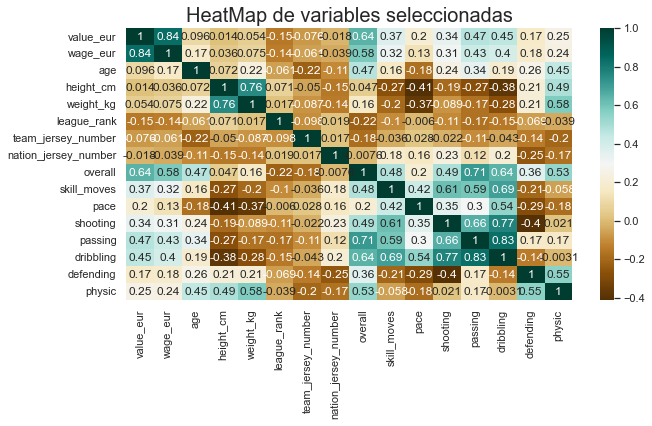

In [13]:
plt.figure(figsize=(10,5))
c = df.corr()
figure_1 = sns.heatmap(c,cmap="BrBG",annot=True)
figure_1.set_title("HeatMap de variables seleccionadas", fontsize = 20)

Del heat map, se observa una alta correlación entre el valor de un jugador y su salario y entre el 'overall' de un jugador y su valor. 
También se observan otras variables con alta correlación pero estas no son consideradas relevantes para este análisis. Sin embargo, a la hora de hacer un análisis estadístico dichas relaciones si deben ser tomadas en cuenta ya que podrían llevar a problemas en el modelo. Pero estas relaciones no presentan nada 'nuevo' a la vez, como por ejemplo la relación entre peso y altura, o entre el overall de un jugador y otros atributos individuales de este.

Luego de identificar las columnas con alta correlación con el valor de un jugador, se procede a realizar un scatter plot entre estas.

#### Salario

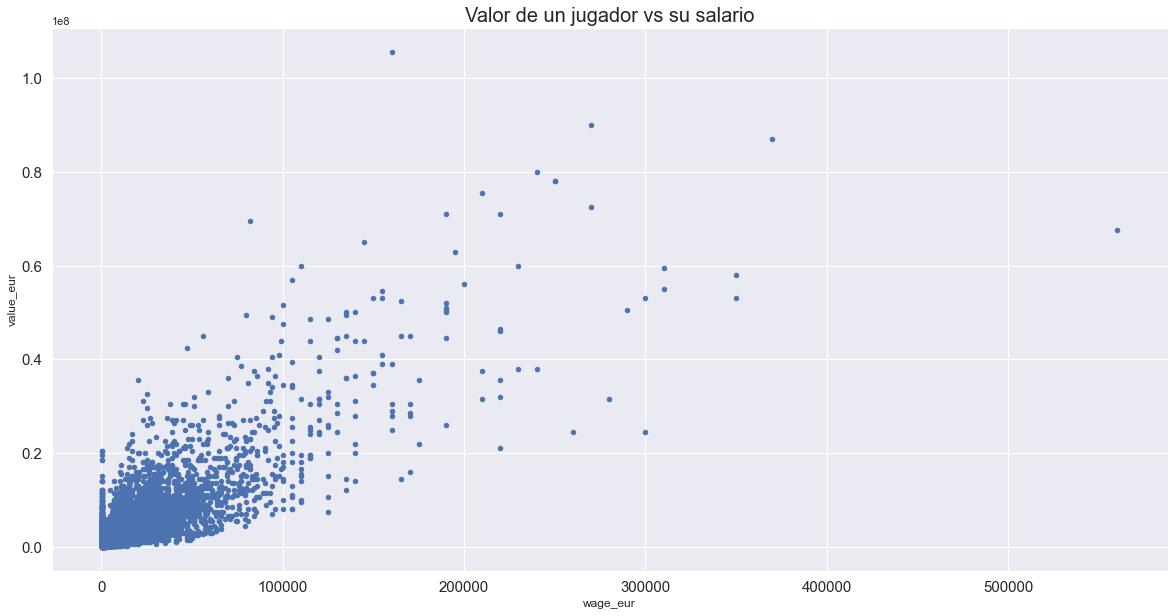

In [14]:
figure_2 = df.plot(x="wage_eur", y="value_eur", kind="scatter", figsize=(20,10), fontsize=15)
figure_2.set_title('Valor de un jugador vs su salario', fontsize = 20)
plt.show()

En el scatter graph se observa que a mayor salario de un trabajador se espera un mayor valor de este. Sin embargo, no es posible identificar una relación lineal entre estas a primera vista.

#### Overall

<AxesSubplot: title={'center': 'Valor de un jugador vs su overall rating'}, xlabel='overall', ylabel='value_eur'>

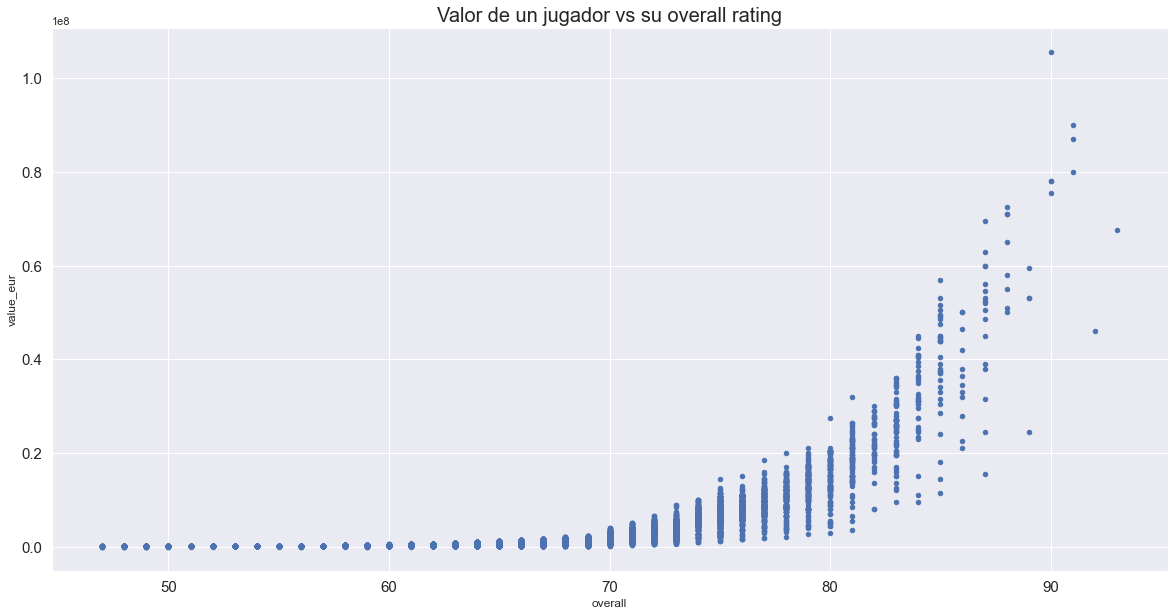

In [15]:
figure_3 = df.plot(x="overall", y="value_eur", kind="scatter", figsize=(20,10), fontsize=15)
figure_3.set_title('Valor de un jugador vs su overall rating', fontsize=20)
figure_3

Este scatter graph presenta dispersión de los datos creciente con el overall de jugador. Se observa que el valor de un jugador tiende a subir cuando el overall de este sube.

#### Número de camiseta

Text(0.5, 1.0, 'Valor medio de jugadores vs número de camiseta')

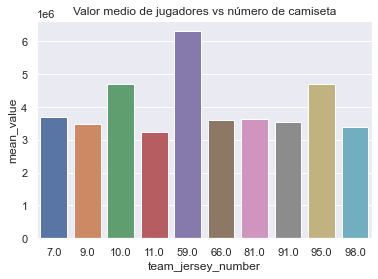

In [16]:
df_avg_val_numero_camiseta = df.groupby(['team_jersey_number']).agg({'value_eur':'mean', 'team_jersey_number':'count'}).sort_values(['value_eur'],ascending=False)
df_avg_val_numero_camiseta.columns = ['mean_value', 'count']
figure_4 = sns.barplot(x=df_avg_val_numero_camiseta.head(10).index, y = df_avg_val_numero_camiseta['mean_value'].head(10))
figure_4.set_title( "Valor medio de jugadores vs número de camiseta")



Del gráfico de barras no se puede deducir nada respecto al precio de los jugadores de acorde al número de camiseta de estos.

76


Text(0.5, 1.0, 'Valor medio de jugadores vs número de camiseta')

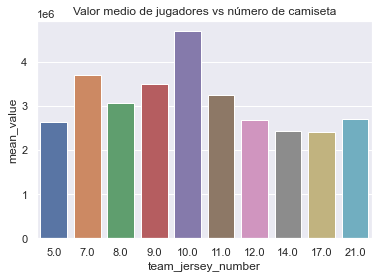

In [17]:
df_avg_val_numero_camiseta = df_avg_val_numero_camiseta[df_avg_val_numero_camiseta['count'] > 100]
print(df_avg_val_numero_camiseta.size)
figure_5 = sns.barplot(x=df_avg_val_numero_camiseta.head(10).index, y = df_avg_val_numero_camiseta['mean_value'].head(10))
figure_5.set_title( "Valor medio de jugadores vs número de camiseta")

Se realizó nuevamente el gráfico pero descartando las camisetas con menos de 100 jugadores ya que estas no eran características de la población. Luego de esto, se puede observar que los jugadores con la camiseta 10 tienen un valor de mercado mayor que el resto, lo cuál era esperable.

#### Pie hábil

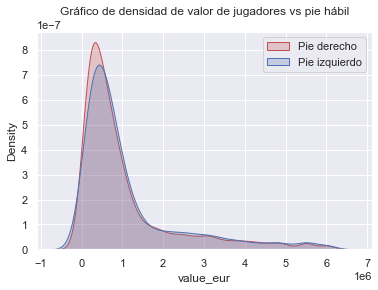

In [18]:
df_pie = df.loc[df["value_eur"] < df["value_eur"].quantile(0.9), ['value_eur', 'preferred_foot'] ] # Se descarta el cuantil 0.95 para que el gráfico sea mas claro
figure_6 = sns.kdeplot(df_pie.loc[df_pie["preferred_foot"] == "Right", "value_eur"], 
            color='r', fill=True)
            
figure_6 = sns.kdeplot(df_pie.loc[df_pie["preferred_foot"] == "Left", "value_eur"], 
            color='b', fill=True)
figure_6.set_title("Gráfico de densidad de valor de jugadores vs pie hábil")
figure_6 = plt.legend(labels=["Pie derecho","Pie izquierdo"])


Se observa una media similar entre ambas distribuciones, pero una distribución más dispersa para el valor de los jugadores con pie hábil izquierdo.

#### País
Como hay muchos países en la base de datos, se decide analizar únicamente una muestra al azar de países.

C:\Users\justo\AppData\Local\Temp/ipykernel_24792/2876571318.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_paises = df[df['nationality'].isin(paises)][df["value_eur"] < df["value_eur"].quantile(0.9)] # Se descarta el cuantil 0.95 para que el gráfico sea mas claro


Text(0.5, 1.0, 'Densidad y distribución de valores de jugadores por país')

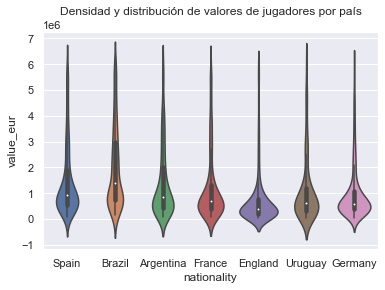

In [43]:
paises = ['Argentina', 'Brazil', 'Spain', 'Uruguay', 'France', 'Germany', 'England']
df_paises = df[df['nationality'].isin(paises)][df["value_eur"] < df["value_eur"].quantile(0.9)] # Se descarta el cuantil 0.95 para que el gráfico sea mas claro

figure_7=sns.violinplot(data=df_paises, x='nationality', y='value_eur')
figure_7.set_title('Densidad y distribución de valores de jugadores por país')

Menos Brasil, todos los países del diagrama muestran una distribución similar. Brasil aparenta tener una distribución más dispersa del precio de sus jugadores.

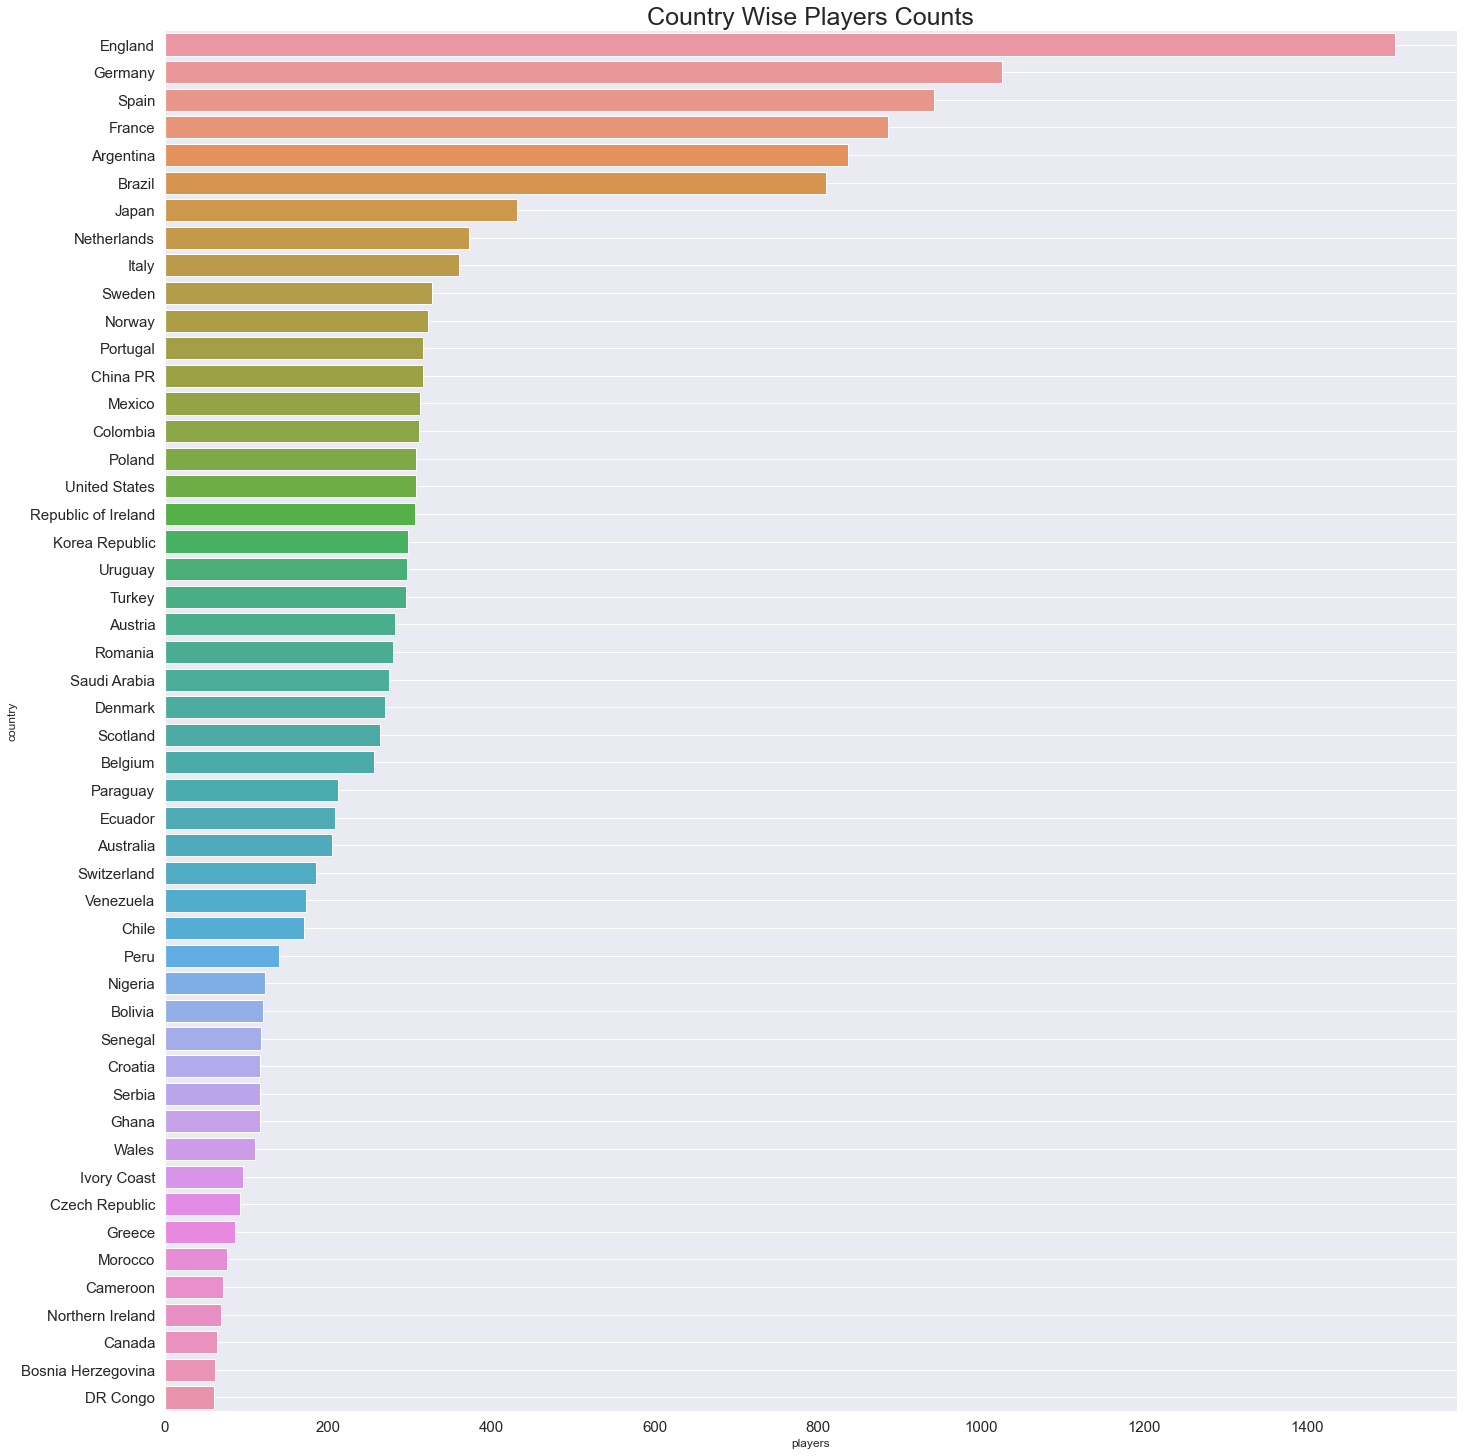

In [51]:
players_per_country = df['nationality'].value_counts().sort_values(ascending=False)
players_per_country = players_per_country.reset_index()
players_per_country.columns = ['country', 'players']
figure_8 = sns.catplot(x='players', y='country' ,data=players_per_country.head(50),height=20,  kind="bar")
figure_8 = plt.title("Country Wise Players Counts",fontsize=25)
figure_8 = plt.yticks(fontsize=15)
figure_8 = plt.xticks(fontsize=15)
figure_8 = plt.grid()
figure_8 = plt.show()



#### Habilidades particulares

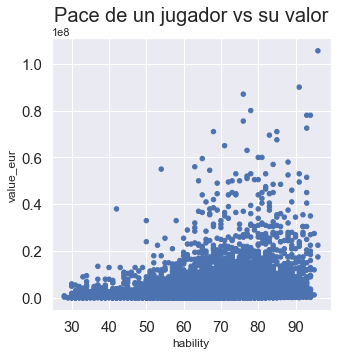

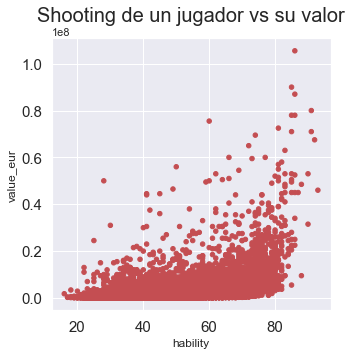

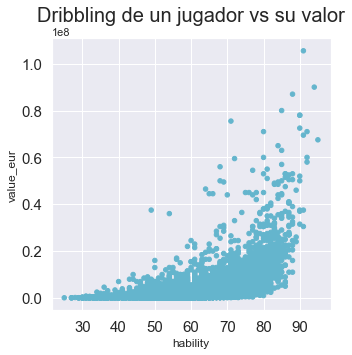

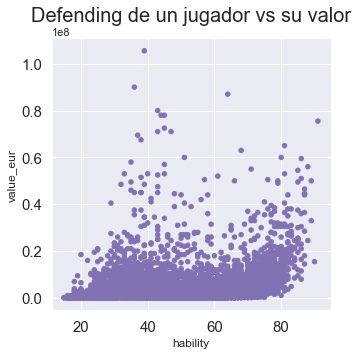

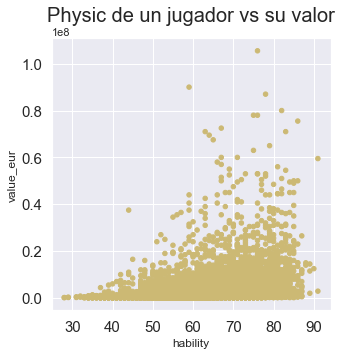

In [50]:
pace = df[['value_eur', 'pace']].rename(columns={'pace':'hability'})
pace['type'] = 'b'
shooting = df[['value_eur', 'shooting']].rename(columns={'shooting':'hability'})
shooting['type'] = 'r'
passing = df[['value_eur', 'passing']].rename(columns={'passing':'hability'})
passing['type'] = 'g'
dribbling = df[['value_eur', 'dribbling']].rename(columns={'dribbling':'hability'})
dribbling['type'] = 'c'
defending = df[['value_eur', 'defending']].rename(columns={'defending':'hability'})
defending['type'] = 'm'
physic = df[['value_eur', 'physic']].rename(columns={'physic':'hability'})
physic['type'] = 'y'

df_habilidades = pd.concat([pace, shooting, defending])

figure_8 = pace.plot.scatter(x='hability', y='value_eur', c='type', alpha=1, figsize=(5,5), fontsize=15)
figure_8.set_title('Pace de un jugador vs su valor', fontsize = 20)
figure_8 = plt.show()

figure_9 = shooting.plot.scatter(x='hability', y='value_eur', c='type', alpha=1, figsize=(5,5), fontsize=15)
figure_9.set_title('Shooting de un jugador vs su valor', fontsize = 20)
figure_9 = plt.show()

figure_10 = dribbling.plot.scatter(x='hability', y='value_eur', c='type', alpha=1, figsize=(5,5), fontsize=15)
figure_10.set_title('Dribbling de un jugador vs su valor', fontsize = 20)
figure_10 = plt.show()

figure_11 = defending.plot.scatter(x='hability', y='value_eur', c='type', alpha=1, figsize=(5,5), fontsize=15)
figure_11.set_title('Defending de un jugador vs su valor', fontsize = 20)
figure_11 = plt.show()

figure_12 = physic.plot.scatter(x='hability', y='value_eur', c='type', alpha=1, figsize=(5,5), fontsize=15)
figure_12.set_title('Physic de un jugador vs su valor', fontsize = 20)
figure_12 = plt.show()
